In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn import metrics, preprocessing
from sklearn.inspection import permutation_importance, plot_partial_dependence
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

#mpl.rcParams["figure.dpi"] = 150

import warnings
warnings.filterwarnings("ignore")
plt.ioff()
# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = (s_mobile["churn"] == "yes").astype(int)

### Exploring descriptive statistics in the training and representative samples

In [3]:
# explore training set values
pd.get_dummies(
    s_mobile.loc[s_mobile.training == 1, "changer":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.661245,28.956823,-62.0,305.0
changem,15.211392,51.885577,-78.0,521.0
revenue,57.211136,43.258950,0.0,856.0
mou,515.322308,525.458925,0.0,7668.0
overage,66.274286,69.258068,0.0,283.0
roam,1.197253,7.254327,0.0,692.0
conference,0.263480,1.083898,0.0,56.0
months,18.781502,9.595614,6.0,61.0
uniqsubs,1.546227,0.891051,1.0,18.0
custcare,2.288132,4.192970,0.0,32.0


In [4]:
# churn in representative model
pd.get_dummies(
    s_mobile.loc[s_mobile.representative == 1, "changer":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.310567,28.496320,-90.0,437.0
changem,17.254533,51.375390,-78.0,540.0
revenue,56.634800,43.339533,0.0,1223.0
mou,540.767067,536.368824,0.0,7359.0
overage,61.723400,67.846131,0.0,265.0
roam,1.187867,10.058579,0.0,1112.0
conference,0.296400,1.284316,0.0,66.0
months,18.592767,9.928488,6.0,61.0
uniqsubs,1.501367,0.840013,1.0,12.0
custcare,2.514533,4.357846,0.0,32.0


Adding case weights to the data


In [5]:
# add case weights
class_weight_dict = {0: 49, 1: 1}
s_mobile["churn_yes"] = (s_mobile["churn"] == "yes").astype(int)
s_mobile["cweight"] = rsm.ifelse(
    s_mobile.churn == "yes", class_weight_dict[1], class_weight_dict[0]
)

In [6]:
eda_plots = rsm.distr_plot(s_mobile.loc[s_mobile.training == 1, "changer":"occupation"])

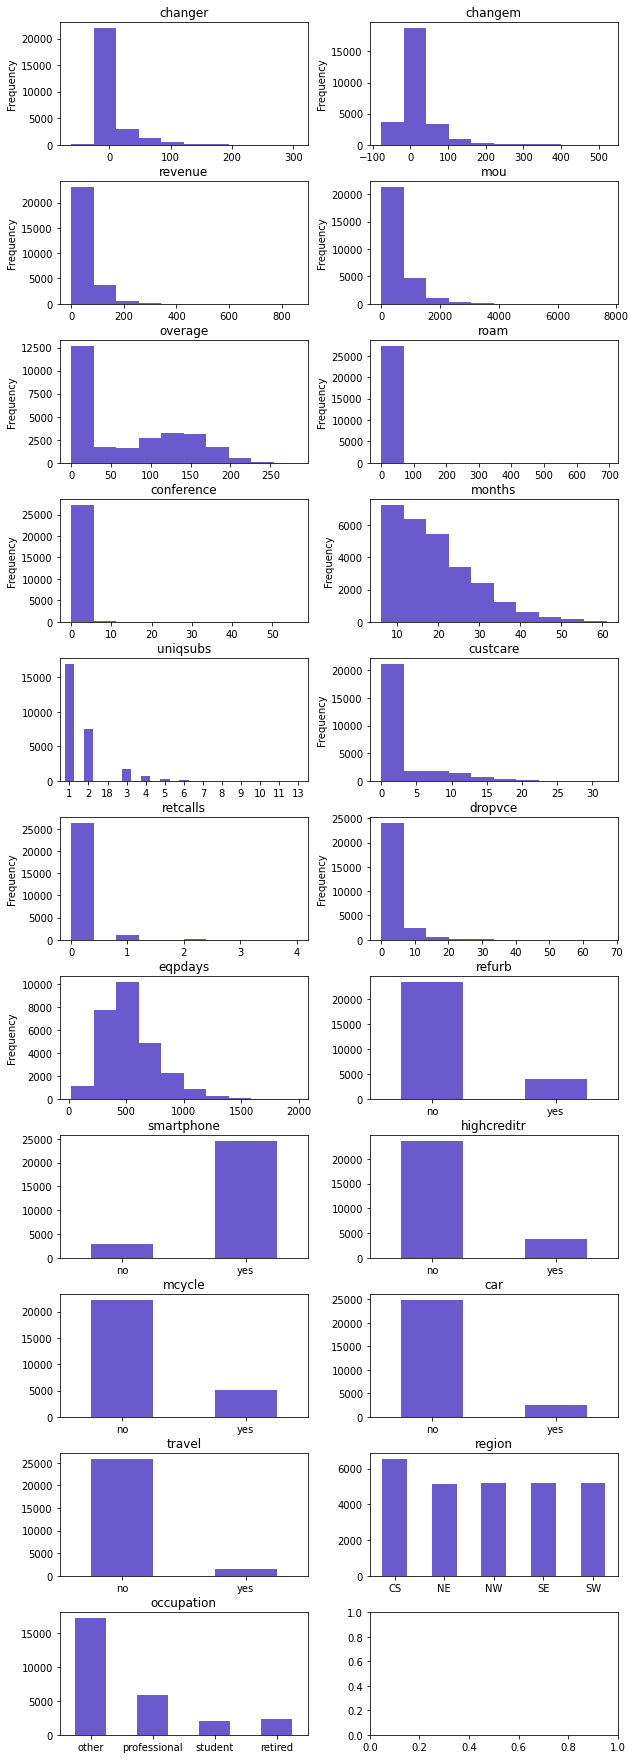

In [7]:
plt.show(eda_plots)

From the plots above, we see some trends and skewness. But since we are working with logistic regression models, it is not of primary concern. There are also some variables which are not interesting. 

Initially, the variables that look like they will have any sort of an impact are heavily skewed. But it also suggests that the model will not have a very high R-squared value.

Before building a logistic model, we did exploratory data analysis (in `eda.ipynb`) to understand the distributions of every variable, as seen in the training sample. Although we notice some of the explanatory variables to be skewed, we do not need to transform them for the sake of this logistic model. 

The `changer` and `changem` variables are heavily skewed, but most of the values are close to 0, suggesting that the data for each customer is more or less around the same in terms of revenue and monthly usage over the span of the 4 months & 30 days of the data collection. The distributions for `revenue` and `mou` also look very similar. The plots for `overage` and `eqpdays` look the most interesting with no clear trend in distribution, thus suggesting they may have an impact on the response variable of our model. The plots for `roam`, `retcalls`, `dropvce`, and `conference` are very heavily skewed with the majority of the customers having values close to 0 for these attributes. 

While the plot for `uniqsubs` has some variability, there is no apparent trend. For the categorical variables, including `refurb`, `smartphone`, `highcreditr`, `mcycle`, `car`, and `travel` the distribution is disproportionate, with the percentage of **no** being higher for all but a variable: `smartphone`. 